## Import the Libraries

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt 
from tqdm import tqdm

## Download the Fashion MNIST Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


##Preprocessing

In [0]:
# x_train originally is [num of samples, image_width, image_height]
# convert it to a shape of [num of samples, image_width * image_height]
x_train = x_train.reshape(60000,-1)
x_test = x_test.reshape(10000,-1)

In [0]:
# the values of x_train and x_test are between 0 and 255
# compute the mean and standard deviation of the train set and 
# normalize the data
def normalize(x_train, x_test):
  train_mean = np.mean(x_train)
  train_std = np.mean(x_train)
  x_train = (x_train - train_mean)/train_std
  x_test = (x_test - train_mean)/train_std  
  return x_train, x_test

In [0]:
# the class labels are numbers between 0 to 9
# convert the class labels into one-hot-encoded representation
def convert_to_one_hot(labels):
  no_samples = labels.shape[0]
  n_classes = np.max(labels) + 1
  one_hot = np.zeros((no_samples, n_classes))
  one_hot[np.arange(no_samples),labels.ravel()] = 1
  return one_hot
  

In [0]:
# preprocess the dataset
x_train, x_test = normalize(x_train, x_test)
y_train = convert_to_one_hot(y_train)
y_test = convert_to_one_hot(y_test)

## Define the placeholders

In [0]:
def get_placeholders(input_size, output_size):
  inputs = tf.placeholder(dtype=tf.float32, shape=[None, input_size], name="inputs")
  targets = tf.placeholder(dtype=tf.float32, shape=[None, output_size], name="targets")
  return inputs, targets

## Routines

Dense Layer - returns a fully connected layer between the inputs and outputs. 

In [0]:
def dense_layer(input, hidden_units, layer_no, activation_fn= tf.nn.relu):
  weights_name = "kernel/{}".format(layer_no)
  bias_name = "biases/{}".format(layer_no)
  weights = tf.get_variable(weights_name, shape=[input.shape[1], hidden_units], initializer = tf.contrib.layers.xavier_initializer(seed=0))
  biases = tf.get_variable(bias_name, shape=[hidden_units], initializer = tf.zeros_initializer())
  output = tf.add(tf.matmul(input, weights), biases)
  if activation_fn:
    return activation_fn(output)
  else:
    return output
                                             

Forward Propagation 

In [0]:
def build_network(features, labels, num_layers, activation_fn):
  inputs = features
  for layer in range(num_layers-1):
    inputs = dense_layer(inputs, hidden_units[layer], layer+1, activation_fn)
    
  # don't apply any activation to the last layer 
  # the loss term will apply the softmax activation
  logits = dense_layer(inputs, 10, num_layers, None) 
  return logits

Compute the loss of the network

In [0]:
def compute_loss(logits, labels):
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels , logits= logits))
  train_op = tf.train.AdamOptimizer(0.001)
  return loss, train_op

Compute the accuracy of the model

In [0]:
def compute_accuracy(logits, labels):
  correct_predictions = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
  accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
  return accuracy

Get all the name of the weights defined in the netowrk

In [0]:
def get_weights_name(num_layers):
  return ["kernel/{}:0".format(layer+1) for layer in range(num_layers)]

Define a function to train the model

In [0]:
def train_model(features, labels, epochs, batch_size, learning_rate, num_layers, activation_fn):
  tf.reset_default_graph()
  input_size = features.shape[1]
  output_size = labels.shape[1]
  
  # get the placeholders 
  inputs, targets = get_placeholders(input_size,output_size)
  
  # create a dataset
  dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
  
  # make the required batches 
  dataset = dataset.batch(batch_size)
  
  # initialize the iterator for the dataset 
  iterator = dataset.make_initializable_iterator()
  
  # get the next batch
  x_batch, y_batch = iterator.get_next()
  
  # forward network
  logits = build_network(x_batch, y_batch, num_layers, activation_fn)
 
  # compute the loss
  loss, train_op = compute_loss(logits, y_batch)
  
  ''' instead of directly using the minimize function on the optimizer, 
   we break the operation into two parts
   1. compute the gradients
   2. apply the gradients
  '''
  grads_and_vars_tensor = train_op.compute_gradients(loss, tf.trainable_variables())
  optimizer = train_op.apply_gradients(grads_and_vars_tensor)
  
  # compute the accuracy of the model
  accuracy = compute_accuracy(logits, y_batch)
  
  init_op = tf.global_variables_initializer()
  saver = tf.train.Saver()
  
  with tf.Session() as sess:
    sess.run(init_op)
    def_graph = tf.get_default_graph()
    gradient_means = []
    losses = []
    accuracies = []
    train_samples = features.shape[0]
    
    iteration = 0
    # get the name of all the trainable variables
    trainable_variables = [var.name for var in tf.trainable_variables()]
    for epoch in range(epochs):
      epoch_loss = 0
      total_accuracy = 0
      # run the iterator's initializer
      sess.run(iterator.initializer, feed_dict={inputs:features, targets:labels})
      try:
        
        while True:
          gradients = []
          batch_loss, grads_and_vars,  _ , batch_accuracy = sess.run([loss, grads_and_vars_tensor, optimizer, accuracy])
          if iteration % 100 == 0:
            
            # create a dictionary of all the trianbale variables and it's gradients
            var_grads = dict(zip(trainable_variables, [grad for grad,var in grads_and_vars]))
            
            # get the gradients of all the weights for all the layers
            weights_grads = [var_grads[var] for var in get_weights_name(num_layers)]
            
            # take the mean of the gradients at each layer
            mean_values = [np.mean(np.abs(val)) for val in weights_grads]
            gradient_means.append(mean_values)
            
          epoch_loss += batch_loss
          total_accuracy += batch_accuracy*batch_size
          iteration += 1
      except tf.errors.OutOfRangeError:
        pass
      print("Total Iterations {}".format(iteration))
      acc = total_accuracy/train_samples
      accuracies.append(acc)
      losses.append(epoch_loss)
      print("Epoch: {}/{} , Loss: {} , Accuracy: {}".format(epoch, epochs, epoch_loss, acc))
      
  return losses, accuracies, gradient_means   
        
      
  
  
  

## Run the model

In [14]:
features = x_train
labels = y_train
epochs = 20
batch_size = 256 
learning_rate = 0.001

num_layers = 5
hidden_units = [30,30,30,30]
input_units = x_train.shape[1]
output_units = y_train.shape[1] 

# run the model for the activation functions sigmoid and relu
activation_fns = {"sigmoid":tf.nn.sigmoid,
                 "relu":tf.nn.relu}

loss = {}
acc= {}
grad={} 

for name, activation_fn in activation_fns.items():
  model_name = "Running model with activation function as {}".format(name)
  print(model_name)
  losses, accuracies, grad_means = train_model(features = features,
              labels = labels, 
              epochs = epochs, 
              batch_size = batch_size, 
              learning_rate = learning_rate, 
              num_layers = num_layers, 
              activation_fn = activation_fn)
  loss[name] = losses
  acc[name] = accuracies
  grad[name] = grad_means

W0704 18:26:01.096787 140217022777216 deprecation.py:323] From <ipython-input-13-29c82128d332>:16: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Running model with activation function as sigmoid


W0704 18:26:03.292783 140217022777216 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Total Iterations 235
Epoch: 0/20 , Loss: 471.16377460956573 , Accuracy: 0.23585555559794108
Total Iterations 470
Epoch: 1/20 , Loss: 322.348956823349 , Accuracy: 0.4638888889312744
Total Iterations 705
Epoch: 2/20 , Loss: 253.96903038024902 , Accuracy: 0.5714166666666667
Total Iterations 940
Epoch: 3/20 , Loss: 206.02589547634125 , Accuracy: 0.6855333333333333
Total Iterations 1175
Epoch: 4/20 , Loss: 171.2326746582985 , Accuracy: 0.74505
Total Iterations 1410
Epoch: 5/20 , Loss: 149.3302248120308 , Accuracy: 0.7711944445292155
Total Iterations 1645
Epoch: 6/20 , Loss: 131.090882897377 , Accuracy: 0.8087555554707845
Total Iterations 1880
Epoch: 7/20 , Loss: 117.3956244289875 , Accuracy: 0.8300611111958821
Total Iterations 2115
Epoch: 8/20 , Loss: 107.62973323464394 , Accuracy: 0.8552055554707845
Total Iterations 2350
Epoch: 9/20 , Loss: 100.6878225505352 , Accuracy: 0.8656333333333334
Total Iterations 2585
Epoch: 10/20 , Loss: 95.79572296142578 , Accuracy: 0.8722166666666666
Total Iter

## Plot accuracy

In [0]:
def plot_accuracy(accuracies, title):
  for name, values in accuracies.items():
    plt.plot(values, label = name)
    plt.legend(title=title)

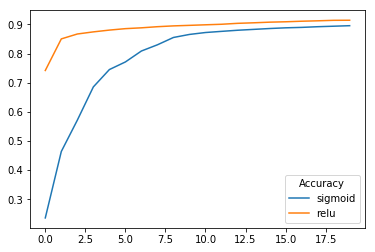

In [16]:
plot_accuracy(acc, "Accuracy")

## Plot the gradients for each layer

In [0]:
def plot_gradients(grads):
  sigmoid = np.array(grads['sigmoid'])
  relu = np.array(grads['relu'])
  for layer_num in range(num_layers):
    plt.figure(figsize=(10,10))
    plt.subplot(5,1,layer_num+1)
    plt.plot(sigmoid[:,layer_num], label='Sigmoid')
    plt.plot(relu[:,layer_num], label='Relu')
    plt.legend(title='Layer{}'.format(layer_num+1))
    

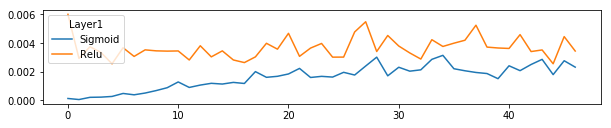

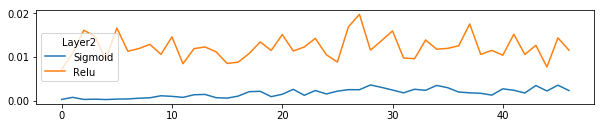

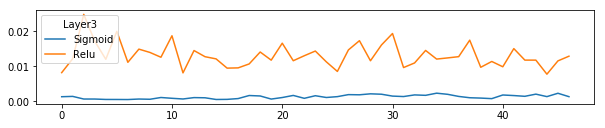

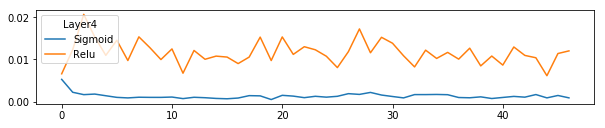

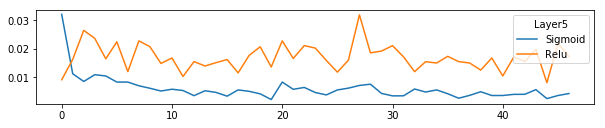

In [20]:
plot_gradients(grad)